# CSINTSY MC01 - SokoBot Analyzer

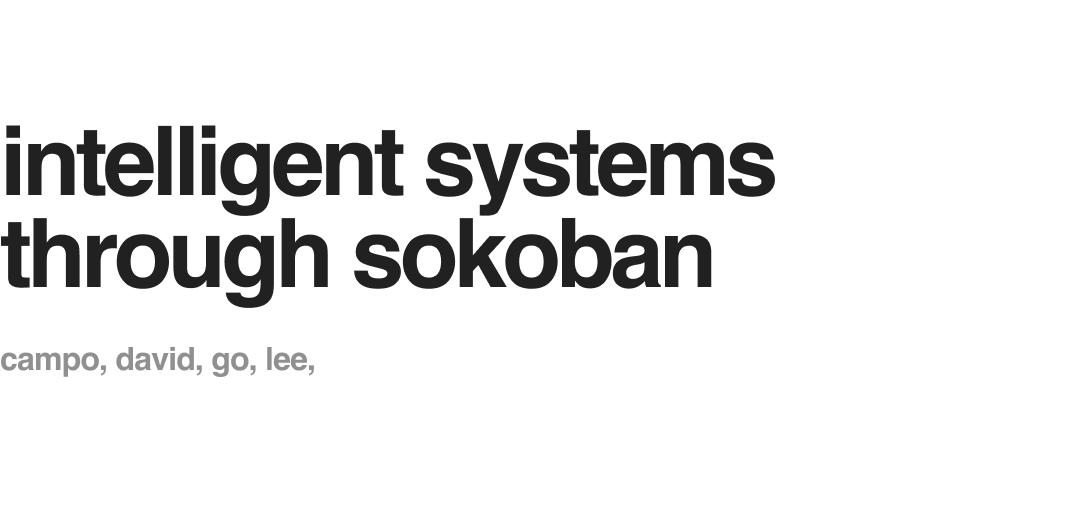

This Jupyter notebook file serves as a basis to analyze the efficiency of our group's sokobot.


## Preprocessing Modules
These are modules needed before running the analyzer. Please make sure to install the packages before running the analyzer.

To install packages, make sure you have the latest installation of pip and do `pip install x` where `x` is the name of the package required.

In [2]:
# Be sure to actually install the packages on your computer
# e.g. pip install pandas

import math
import warnings
import pandas as pd
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# Some settings to help.
warnings.filterwarnings('ignore')
pd.set_option('display.width', 1000)
 

These are constants needed for the analysis to work. Some constants are there to help visualize the given data collected. 

You may change the settings of graphs look through here.

In [3]:
# The CSV file to import
CSV_FILE = "result_tests.csv"

# ANSI Escape code
RESET_COLORS = "\033[0m" 

# Some colors to pick out 
INFO_COLORS = {
    "test_name":        "#ff63b7", 
    "test_file":        "#ff6951", 
    "time_taken":       "#ff8800",
    "no_of_move":       "#fcaf00",
    "no_of_crates":     "#acd100",
    "has_bot_won":      "#00e75b",
    "solution":         "#00edc4",
    "width_of_map":     "#00e2ff",
    "height_of_map":    "#00caff",
    "number_of_blocks": "#82abff",
    "child_nodes_made": "#d98dff",
    "nodes_expanded":   "#ff74ff",
    "branching_factor": "#ea82ff",
    "map_density":      "#3ac3ff"
}

# Additional colors to highlight colors
COLORS = {
    "RED" : "#FF0000",
    "GREEN": "#00FF00"
}

BASIS_STATS = {
    "Mean   :" : "mean",
    "Median :" : "median",
    "Max    :" : "max",
    "Min    :" : "min",
    "Sum    :" : "sum"
}

### Coloring and Visualization
These functions help with analyzing data in a much visually significant way.

Not only that, it makes the graphs aesthetically pleasing to analyze.

In [4]:
# Colors text output of some functions.
def hex_to_rgb(hex_code: str) -> tuple[int, int, int]:
    """Turns hexcode to rgb

    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        tuple(int, int, int): a tuple containing rgb information
    """
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i + 2], 16) for i in (0, 2, 4))

def rgb_to_ansi_rgb(r, g, b):
    """Turns rgb values to ANSI escape codes

    Args:
        r (int): red
        g (int): green
        b (int): blue

    Returns:
        str: Equivalent Ansi Escape code.
    """
    return f"\033[38;2;{r};{g};{b}m"

def colored_text(hex_code) -> str:
    """colors text output 
    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        str: Equivalent Ansi Escape code.
    """
    r, g, b = hex_to_rgb(hex_code)
    ansi_color = rgb_to_ansi_rgb(r, g, b)
    return ansi_color;

def rgb_to_hex(rgb: tuple[str, str, str]) -> str:
    """Generate a hexcode string from a rgb tuple

    Args:
        rgb (tuple[str, str, str]): 3-tuple representation of rgb values

    Returns:
        str: hexcode of the rgb values
    """
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

def mix_colors(hex_code1: str, hex_code2: str) -> str:
    """Mixes two colors together 

    Args:
        hex_code1 (str): string of color 1's hex code
        hex_code2 (str): string of color 2's hex code

    Returns:
        str: the mixed color's rgb code
    """
    # Unpack the RGB values
    r1, g1, b1 = hex_to_rgb(hex_code1)
    r2, g2, b2 = hex_to_rgb(hex_code2)
    
    # Average the RGB values
    mixed_color = (
        (r1 + r2) // 2, 
        (g1 + g2) // 2, 
        (b1 + b2) // 2
    )
    
    return rgb_to_hex(mixed_color)

def print_essay(essay: list[str]) -> None:
    """Concatenates a list of strings, then prints them in a single println statement.

    Args:
        essay (list[str]): List of sentences you want to output
    """
    output: str = str("");
    for sentence in essay:
        output += ('\n' + sentence);
    print(output)

def calculate_percent(partial: int, total: int):
    return (0, partial/total * 100)[total > 0]

def str_percentage_bar(partial: int, total: int, length = 30) -> str:
  percent = calculate_percent(partial, total)
  bar_length = int(length * percent // 100)
  full_char = '█'
  empty_char = '-'
  
  str_bar: str =  (f'{colored_text(COLORS['GREEN'])}' + 
                   f'{full_char}' * bar_length + 
                   f'{colored_text(COLORS['RED'])}' + 
                   f'{empty_char}' * (length - bar_length) +
                   f'{(RESET_COLORS)}')
  
  return f'[{str_bar}]({percent: .2f} % )'


These sections contains helpful functions that preprocess the dataframe. A few can convert columns into analyzable data.


In [5]:
# Functions to preprocess the data.
def create_logs_of_colmn(df: pd.DataFrame, col_names: list[str]):
    """Create the logarithm of a list of column names

    Args:
        df (pd.DataFrame): dataframe to modify
        col_names (list[str]): list of strings to modify
    """
    for col_name in col_names:
        df["log_{}".format(col_name)] = df[col_name].agg(math.log)


def remove_seconds(input: str):
    """Used as an aggregate function to strip the seconds unit

    Args:
        input (str): numeric containing s at the end

    Returns:
        str: String with removed string unit
    """
    return input.rstrip("s"); 

def preprocess_df(df: pd.DataFrame) -> None:
    """Preprocesses dataframe for compatability. Turns the type of time_taken to float.

    Args:
        df (pd.DataFrame): dataframe to modify
    """
    # Time str into float
    df["time_taken"] = df["time_taken"].transform(remove_seconds)
    df["time_taken"] = df["time_taken"].astype(float);
    
    df["branching_factor"] = df["child_nodes_made"] / df["nodes_expanded"]
    
    df["map_size"] = df ["width_of_map"] * df["height_of_map"]
    df["map_density"] = (df["map_size"]) / df["number_of_blocks"] 
    
    # Needed for 
    df["has_bot_win_numeric"] = df["has_bot_won"].astype(int);



def sum_statistics(df: pd.DataFrame) -> None:
    """Summarizes some statistics per item and prints them.

    Args:
        df (pd.DataFrame): dataframe to modify
    """
    str_stats = ""
    
    for col, color in INFO_COLORS.items():
        sum_statistics.concat("\nStatistics of " + colored_text(color) + col + RESET_COLORS + ":\n")
        sum_statistics.concat("mean, median (min, max)\n{}, {} ({}, {})\n".format(
            round(df[col].agg("mean")   , 3),
            round(df[col].agg("median") , 3),
            round(df[col].agg("max")    , 3),
            round(df[col].agg("min")    , 3),
        ))
    print(str_stats) 
    


In [6]:
# Generates scatter plots

def generate_normal_scatter(df: pd.DataFrame, col_name: str):
    """Generates a pyplot scatter plot with the index as the x_axis and a column as the y_axis

    Args:
        df (pd.DataFrame): dataframe to inspect
        col_name (str): 
    """
    plt.scatter(df.index, 
                df[col_name], 
                s = 10, 
                color = INFO_COLORS[col_name]);
    plt.xlabel("index");
    plt.ylabel(col_name);
    plt.title("Statistic for {}".format(col_name));
    plt.grid();

    
def genenerate_tuple_scatter(df: pd.DataFrame, col_tuple: tuple[str, str]):
    """Generates a pyplot graph with the col_tuple[0] as the x_axis and col_tuple[1] as the y_axis

    Args:
        df (pd.DataFrame): dataframe to plot from
        col_tuple (tuple[str, str]): tuple of strings that represent (x, y) values.
    """
    df.sort_values(col_tuple[0]);
    plt.scatter(df[col_tuple[0]], 
                df[col_tuple[1]], 
                s = 10, 
                color = mix_colors(INFO_COLORS[col_tuple[0]], INFO_COLORS[col_tuple[1]]))
    plt.xlabel(col_tuple[0]) 
    plt.ylabel(col_tuple[1])
    plt.title("Statistic for {} vs {}".format(col_tuple[0], col_tuple[1]))
    plt.grid()

def generate_3d_scatter(df: pd.DataFrame, tuple_col: tuple[str, str, str], cmap_col = ""):
    """Generate 3d scatter plot based on three Series, with the possible inclusion of a fourth one by domain coloring

    Args:
        df (pd.DataFrame): 
        tuple_col (tuple[str, str, str]):  tuple of strings that represent the names of series for (x, y, z) values.
        cmap_col (str, optional): string of the name of the series to do domain coloring. Defaults to "".
    """
    x = df[tuple_col[0]]
    y = df[tuple_col[1]]
    z = df[tuple_col[2]]
    w = df[cmap_col]

    # Creating figure
    fig = plt.figure(figsize = (16, 9))
    ax  = plt.axes(projection ="3d")
    
    # Add x, y gridlines 
    ax.grid(
        b = True, 
        color ='grey', 
        linestyle ='-.', 
        linewidth = 0.3, 
        alpha = 0.2
    ) 
    
    # Creating color map
    my_cmap = plt.get_cmap('hsv')
    
    
    # Creating plot
    sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = w, 
                    cmap = my_cmap, 
                    marker ='^')
    
    plt.title("Statistics of {}, {}, {} and ".format(tuple_col[0], tuple_col[1], tuple_col[2]))
    ax.set_xlabel(tuple_col[0], fontweight ='bold') 
    ax.set_ylabel(tuple_col[1], fontweight ='bold') 
    ax.set_zlabel(tuple_col[2], fontweight ='bold')
    
    cbar = fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label(cmap_col, rotation=270, labelpad=20, fontweight='bold')  # Label the color bar

    # show plot
    plt.grid()
    plt.show()

# Analysis of Sokobot data
This portion deals with the analysis of the data that `tester.py` produces. 

It tests on 2750 different maps. Some maps are given my Ms. Shirley Chu of De La Salle University, while others are webscrapped from the internet. 

Tests where run on a computer with the following specs:
 - OS and Manufacturer: Windows 10, Microsoft Corporation
 - System Type: x64-based PC 
 - Processor: AMD Ryzen 5 3500 6-Core Processor, 3600 Mhz, 6 Core(s), 6 Logical Processor(s)
 - Installed Physical Memory (RAM): 16.0 GB 
 - GPU: NVIDIA GeForce GTX 1660 SUPER 

First, preprocess the dataframe to clean the data and add necessary values. 

Then, separate them into two different groups: 
- when the Sokobot won and successfully created a solution, and 
- when the Sokobot lost and was timed out.

Map of Contents:
- Success Rate:
  - Crate Count
  - 
- Branching Factor
- Moves to Completion
- Memory 

In [7]:
# Read the given CSV file within the same directory of the folder
df = pd.read_csv(CSV_FILE)

preprocess_df(df)
# Separate two different datasets
df_sucessful    = df[df["has_bot_won"] == True];
df_failed       = df[df["has_bot_won"] == False];

## Quick Overview of Data.
Here's a view of the data at first glance.

In [8]:
# Print the first few rows
print("Review some sample data from the database.\n")
print(df.head())


Review some sample data from the database.

  test_name test_file  time_taken  no_of_move  no_of_crates  has_bot_won                                           solution  width_of_map  height_of_map  number_of_blocks  child_nodes_made  nodes_expanded  branching_factor  map_size  map_density  has_bot_win_numeric
0     base1     base1        0.08          25             2         True                          ldrrrurulddlllurrurulldlu             7              7                29               882             481          1.833680        49     1.689655                    1
1     base2     base2        0.08          18             2         True                                 drrrrulldlurrruull             8              7                32               710             399          1.779449        56     1.750000                    1
2     base3     base3        0.09          47             2         True    dddruuurrrdddluurullluuurrrdllrddllulldrldrdruu            11              9   

In [9]:
print("Handy statistics of the dataframe:")
print(df.describe())

Handy statistics of the dataframe:
        time_taken   no_of_move  no_of_crates  width_of_map  height_of_map  number_of_blocks  child_nodes_made  nodes_expanded  branching_factor     map_size  map_density  has_bot_win_numeric
count  2750.000000  2750.000000   2750.000000   2750.000000    2750.000000       2750.000000      2.750000e+03    2.750000e+03       2750.000000  2750.000000  2750.000000          2750.000000
mean      9.059193    59.682545      7.880000     11.560000      10.570182         91.320364      1.060005e+06    7.049145e+05          1.440693   130.304000     1.407976             0.443273
std       6.935732    80.745129      3.997016      4.047265       3.004299         59.643688      8.338980e+05    5.686412e+05          0.215133    96.907853     0.142045             0.496862
min       0.060000     1.000000      1.000000      5.000000       3.000000         15.000000      1.000000e+00    1.000000e+00          1.000000    15.000000     1.000000             0.000000
25%  

## Correlation Maps
Correlation maps help distinguish what values correlate with each other

In [10]:
# Correlation map by Spearman
numeric_df = df_sucessful[
    ["nodes_expanded", "child_nodes_made", "map_density", "no_of_crates", "no_of_move", "number_of_blocks", "time_taken", "has_bot_win_numeric", "map_size"]
]

corr_map_spearman = numeric_df.corr(method='spearman').fillna(0)

def color_percentage(val):
    color: str
    if val == 1.0:
        color = 'black'
    elif val > 0.9:
        color = 'lightblue'     # Highest correlations
    elif val > 0.5:
        color = 'lightgreen'    # Strong positive correlation
    elif val > -0.5:
        color = 'white'         # Mild positive correlation
    elif val > -0.9:
        color = 'orange'         # Mild negative correlation
    else:
        color = 'red'            # Strong negative correlation
    
    return f'background-color: {color}; color: black;'

corr_map_spearman = corr_map_spearman.style.applymap(color_percentage);
corr_map_spearman

,nodes_expanded,child_nodes_made,map_density,no_of_crates,no_of_move,number_of_blocks,time_taken,has_bot_win_numeric,map_size
nodes_expanded,1.000000,0.999259,0.181384,0.762535,0.579984,0.566400,0.976987,0.000000,0.596492
child_nodes_made,0.999259,1.000000,0.185048,0.767080,0.561254,0.560280,0.977501,0.000000,0.592460
map_density,0.181384,0.185048,1.000000,-0.046352,0.195003,0.037071,0.171963,0.000000,0.254441
no_of_crates,0.762535,0.767080,-0.046352,1.000000,0.191981,0.187386,0.793147,0.000000,0.184766
no_of_move,0.579984,0.561254,0.195003,0.191981,1.000000,0.566071,0.516933,0.000000,0.583921
number_of_blocks,0.566400,0.560280,0.037071,0.187386,0.566071,1.000000,0.519302,0.000000,0.962245
time_taken,0.976987,0.977501,0.171963,0.793147,0.516933,0.519302,1.000000,0.000000,0.548581
has_bot_win_numeric,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
map_size,0.596492,0.592460,0.254441,0.184766,0.583921,0.962245,0.548581,0.000000,1.000000


## Success rate 
Win rate measures the likelihood for the sokobot to find a solution within 15.0 seconds in a given map.


The figure below describes how likely

In [11]:
# Overall in most games
essay_overall_wins = [
    "How many tests have sokobot won in General?",
    "{}Won{}      : {}".format(colored_text(COLORS["GREEN"]),  RESET_COLORS, str(df_sucessful.shape[0])),
    "{}Fail{}     : {}".format(colored_text(COLORS["RED"]), RESET_COLORS, str(df_failed.shape[0])),
    "---------+--------------------------------",
    "Win Rate : {}% of out of {} tests".format(str(round(df_sucessful.shape[0] / df.shape[0] * 100, 2)), str(df.shape[0])),
    f"{str_percentage_bar(partial=df_sucessful.shape[0], total=df.shape[0])}\n"
]

print_essay(essay_overall_wins)



How many tests have sokobot won in General?
Won      : 1219
Fail     : 1531
---------+--------------------------------
Win Rate : 44.33% of out of 2750 tests
[█████████████-----------------]( 44.33 % )



In [12]:
# Count has_bot_won per crate count
pt_cc_total_maps = df.pivot_table(index='no_of_crates', values='has_bot_won', aggfunc='count')

# Sum the true has_bot_won per crate count
pt_cc_has_won = df.pivot_table(index='no_of_crates', values='has_bot_won', aggfunc='sum')


essay_total_wins_per_total_maps = ["Win percentage of maps per crate count:\n"]

for (no_of_crates, series_total_maps), (_, series_no_of_wins_series) in zip(pt_cc_total_maps.iterrows(), pt_cc_has_won.iterrows()):
  no_of_wins = series_no_of_wins_series["has_bot_won"]
  total_maps = series_total_maps["has_bot_won"]
  
  percent = (0, no_of_wins/total_maps * 100)[total_maps > 0]
  essay_total_wins_per_total_maps.append(f'crates: {no_of_crates}, wins \\ total_maps: {no_of_wins}/{total_maps}')
  essay_total_wins_per_total_maps.append(f'{str_percentage_bar(partial=no_of_wins, total=total_maps)}\n')

print_essay(essay_total_wins_per_total_maps)


Win percentage of maps per crate count:

crates: 1, wins \ total_maps: 21/26
[████████████████████████------]( 80.77 % )

crates: 2, wins \ total_maps: 88/89
[█████████████████████████████-]( 98.88 % )

crates: 3, wins \ total_maps: 299/299
[██████████████████████████████]( 100.00 % )

crates: 4, wins \ total_maps: 289/302
[████████████████████████████--]( 95.70 % )

crates: 5, wins \ total_maps: 177/210
[█████████████████████████-----]( 84.29 % )

crates: 6, wins \ total_maps: 184/277
[███████████████████-----------]( 66.43 % )

crates: 7, wins \ total_maps: 71/166
[████████████------------------]( 42.77 % )

crates: 8, wins \ total_maps: 65/289
[██████------------------------]( 22.49 % )

crates: 9, wins \ total_maps: 12/179
[██----------------------------]( 6.70 % )

crates: 10, wins \ total_maps: 7/197
[█-----------------------------]( 3.55 % )

crates: 11, wins \ total_maps: 5/106
[█-----------------------------]( 4.72 % )

crates: 12, wins \ total_maps: 1/186
[------------------

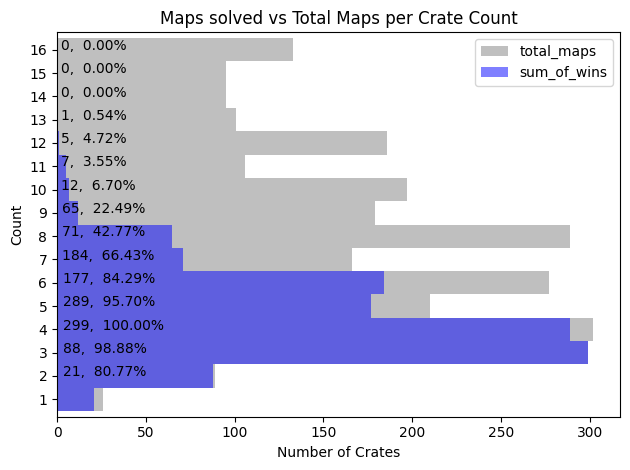

In [13]:
# Plotting both the total maps and wins on the same graph
ax = pt_cc_total_maps.plot(kind='barh', legend=False, alpha=0.5, color='gray', width=1)

# Adding labels on top of the 'sum_of_wins' bars
for (index, series_partial), (_, series_total) in zip(pt_cc_has_won.iterrows(), pt_cc_total_maps.iterrows()):
    partial = series_partial['has_bot_won']
    total = series_total['has_bot_won']
    percent = calculate_percent(partial, total)
    ax.annotate(f'{int(partial)}, {percent: .2f}%', xy=(partial/total * 100, index), xytext=(3, -0.15), textcoords='offset points')

# Plot on the same axis
pt_cc_has_won.plot(kind='barh', ax=ax, color='blue', alpha=0.5, width=1)

plt.title('Maps solved vs Total Maps per Crate Count')
plt.xlabel('Number of Crates')
plt.ylabel('Count')
plt.legend(['total_maps', 'sum_of_wins'], loc='upper right')
plt.tight_layout()

# Show the updated plot
plt.show()

##  

In [14]:

from IPython.display import display, Math
essay_overall_branch_factor = [
    "What is the estimated weighted average for the branching factor for sokobot?",
    "Overall Branching factor: {}".format(round(df["branching_factor"].agg("mean"), 2))
]
print_essay(essay_overall_branch_factor)
display(Math(r'B_{o} = {%f}' % (df["branching_factor"].agg("mean"))))

essay_winning_factor = [
    "For tests that are solvable in 15.0 seconds, what is the branching factor?",
    "Wins Branching factor: {}".format(round(df_sucessful["branching_factor"].agg("mean"), 2))
]
print_essay(essay_winning_factor)
display(Math(r'B_{w} = {%f}' % (df_sucessful["branching_factor"].agg("mean"))))


essay_failing_factor_factor = [
    "For tests that failed, what is the branching factor?",
    "Fail Branching factor: {}".format(round(df_failed["branching_factor"].agg("mean"), 2))
]
print_essay(essay_failing_factor_factor)
display(Math(r'B_{l} = {%f}' % (df_failed["branching_factor"].agg("mean"))))



What is the estimated weighted average for the branching factor for sokobot?
Overall Branching factor: 1.44


<IPython.core.display.Math object>


For tests that are solvable in 15.0 seconds, what is the branching factor?
Wins Branching factor: 1.29


<IPython.core.display.Math object>


For tests that failed, what is the branching factor?
Fail Branching factor: 1.56


<IPython.core.display.Math object>

How does time to solve correlate with the number of crates?

In [15]:

print("Time taken to solve for each increase in the number of crates:")
df_avg_time_taken_per_crate = df_sucessful.pivot_table(index="no_of_crates", values="time_taken", aggfunc="mean")


Time taken to solve for each increase in the number of crates:


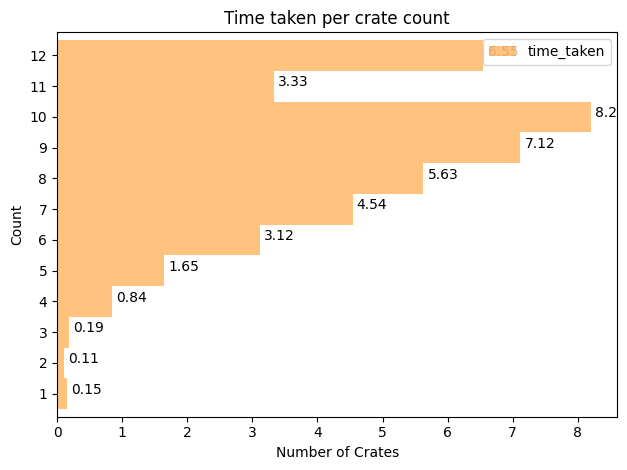

In [16]:
# Plotting both the total maps and wins on the same graph
ax = df_avg_time_taken_per_crate.plot(kind='barh', legend=False, alpha=0.5, color=INFO_COLORS['time_taken'], width=1)

# Adding labels on top of the 'sum_of_wins' bars
for index, value in enumerate(df_avg_time_taken_per_crate['time_taken']):
    ax.annotate(str(round(value, 2)), xy=(value, index), xytext=(3, -0.15), textcoords='offset points')


plt.title('Time taken per crate count')
plt.xlabel('Number of Crates')
plt.ylabel('Count')
plt.legend(['time_taken'], loc='upper right')
plt.tight_layout()

# Show the updated plot
plt.show()


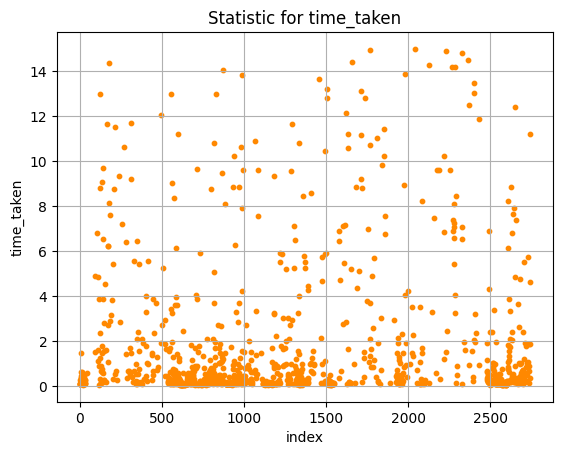

In [17]:
generate_normal_scatter(df_sucessful, "time_taken")

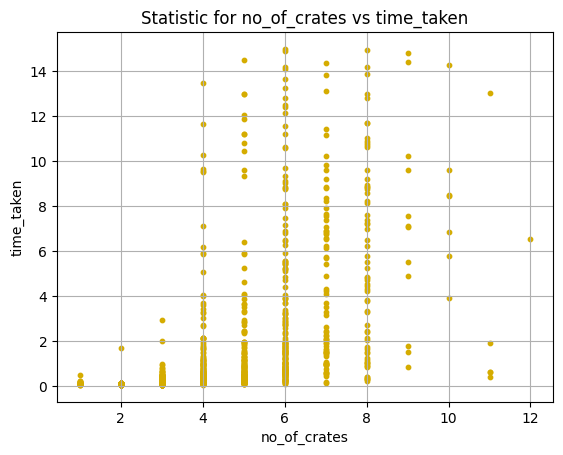

In [18]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "time_taken"))

time_taken     1.667178
map_density    1.378785
dtype: float64

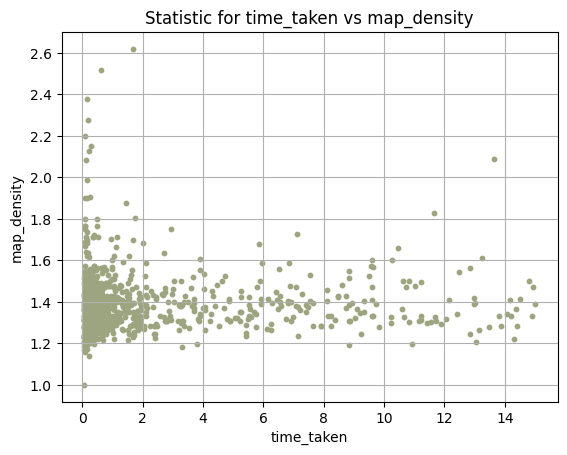

In [19]:
genenerate_tuple_scatter(df_sucessful, ("time_taken", "map_density"))
df_sucessful[["time_taken", "map_density"]].agg('mean')


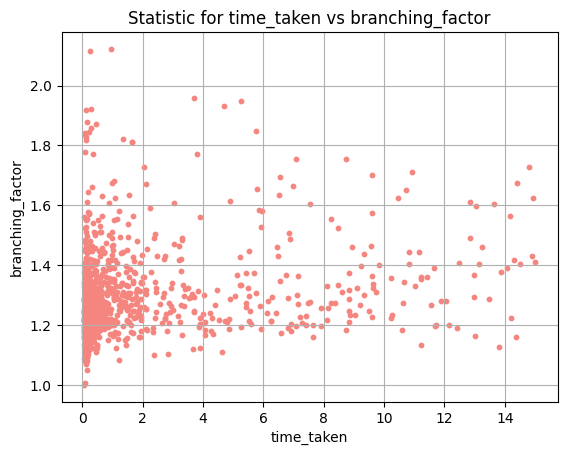

In [20]:
genenerate_tuple_scatter(df_sucessful, ("time_taken", "branching_factor"))

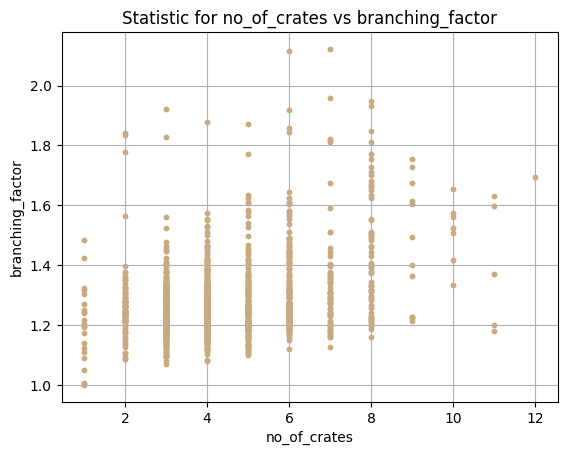

In [21]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "branching_factor"))

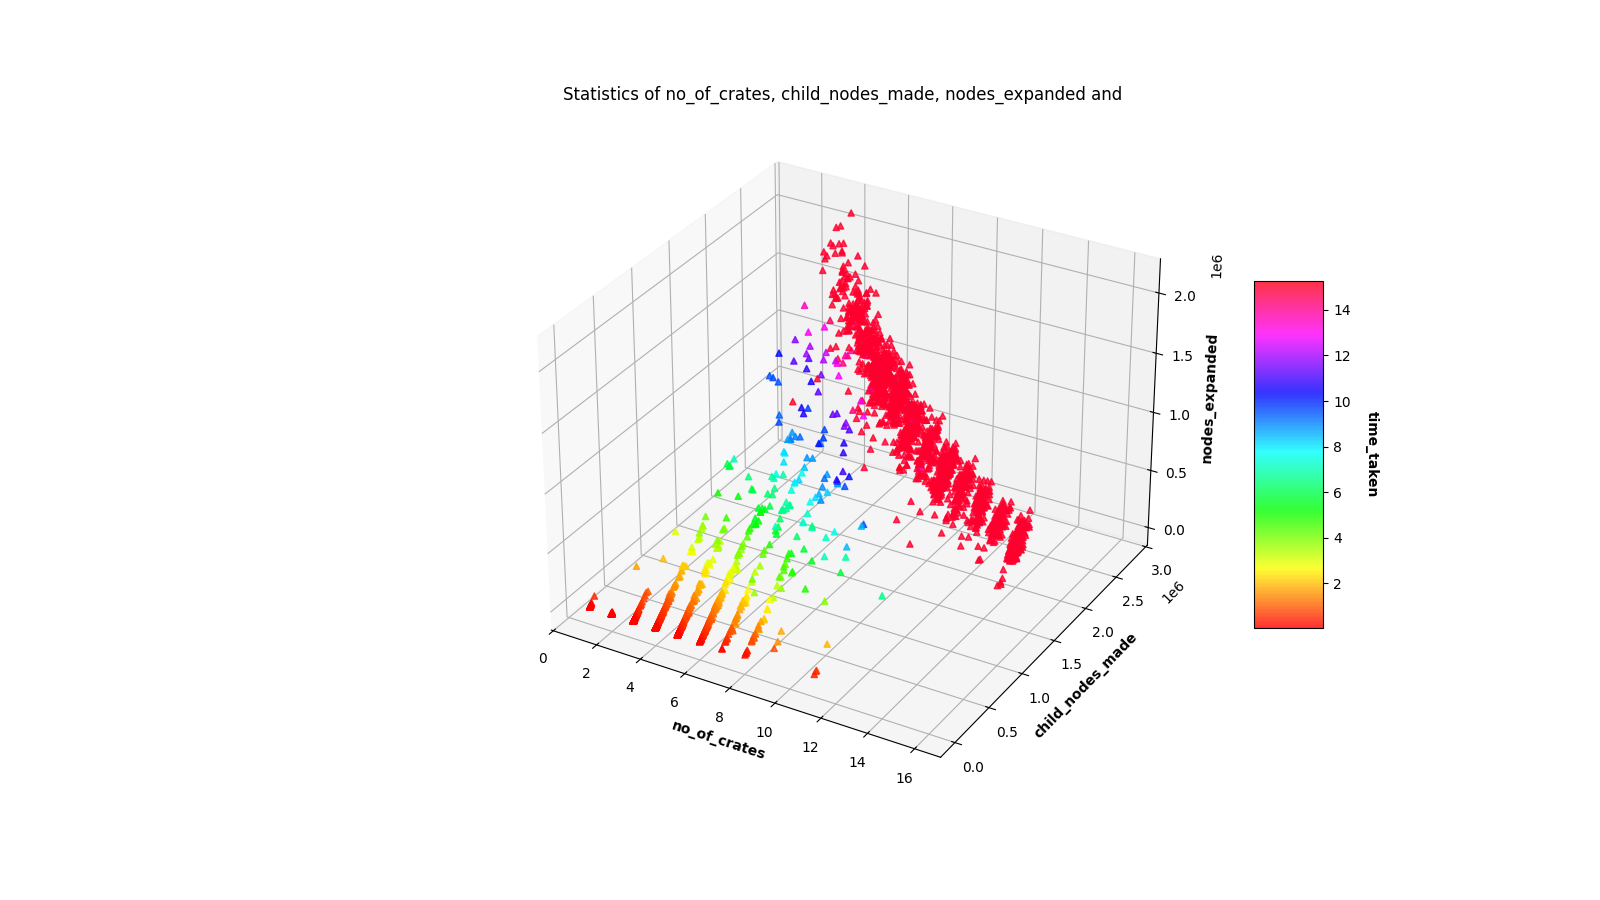

In [22]:
%matplotlib widget

generate_3d_scatter(df, ("no_of_crates", "child_nodes_made", "nodes_expanded"), "time_taken")

In [ ]:
generate_3d_scatter(df, ("child_nodes_made", "nodes_expanded", "no_of_move"), "time_taken")

In [22]:
plt.show()